# Preprocessing Pipeline

### Imports

In [1]:
import os.path
import pyxdf
import mne
from os import path
import numpy as np
import matplotlib.pyplot as plt
from tkinter import Tk
from tkinter.filedialog import askdirectory
import glob, os
import promptlib 

### Constants

In [3]:
TIME_OFFSET = -1  # in sec, the event window begins x seconds before the time stamp
DUR = 5 # in sec, duration of the event window in seconds
EVENTS = {
    'Baseline' : None,
    'MI' : 'MI trial marker',
    'PO' : 'Unity.Marker.TargetID'
}
EPOCH_VAR = {
    'TIME_OFFSET' : TIME_OFFSET,
    'DUR' : DUR,
    'EVENTS' : EVENTS
}


### Functions

In [149]:
def select_stream(stream_data, selection='type',desired_type='EEG'):
    
    for stream in stream_data:
        stream_type = stream['info'][selection][0]
        
        if stream_type == desired_type:
            return stream
        else:
            continue

def select_eegs(xdf_files):
    
    eeg_files = []

    for file in xdf_files:
        print('Processing {}'.format(file))
        data,header = pyxdf.load_xdf(file)
        eeg_file = select_stream(data)
        eeg_file['file'] = os.path.basename(os.path.normpath(file))
        eeg_files.append(eeg_file)
    
    return eeg_files

def raw_processing(raw,fmin=0.1,fmax=40,bad_chs=['M1','M2','EOG']):
    original_raw = raw.copy()
    rawBP = raw.filter(0.1,40)
    rawBP.info['bads'].extend(bad_chs)
    rawBPCAR, ref_data = mne.set_eeg_reference(rawBP, ref_channels='average', copy=True)
    return rawBPCAR
    
def to_mne(data_path, EPOCH_VAR, NB_CHANNELS = 64):
    stream,header = pyxdf.load_xdf(data_path)
    stream_eeg = select_stream(stream)
    ch_names = []
    channels = stream_eeg['info']['desc'][0]['channels'][0]['channel']

    for channel in channels:
        current_label = channel['label'][0]
        if (current_label != 'AUX3') & (current_label != 'TRIGGER'):
            ch_names.append(channel['label'][0])
        else:
            continue

    data = stream_eeg["time_series"].copy().T  # data.shape = (nb_channels, nb_samples)
    data = data[0:64,:] # We do not keep data for AUX3 and TRIGGER
    data *= 1e-6  # convert from uV to V (mne uses V)
    print(len(ch_names))
    assert len(data) == NB_CHANNELS      
    sfreq = float(stream_eeg["info"]["nominal_srate"][0])
    ch_types = ['eeg'] * 64
    info = mne.create_info(ch_names, sfreq, ch_types)
    # info = mne.create_info(NB_CHANNELS, sfreq)
    raw = mne.io.RawArray(data, info)

    ### Filtering and CAR
    rawBPCAR = raw_processing(raw)

    ### Epoch management
    EVENTS = EPOCH_VAR['EVENTS']
    file = os.path.basename(os.path.normpath(data_path))
    event_keys = list(EVENTS.keys())
    event_type = [key for key in event_keys if key in file][0]
    
    if event_type == 'PO':
        
        t_origin = stream_eeg['time_stamps'][0]
        event_id = {
            'Left':2,
            'Right':5,
            'Third':8
        }
        stream_event = select_stream(stream,'name',EVENTS[event_type])
        events = np.zeros((len(stream_event['time_stamps']),3))
        events[:,0] = stream_event['time_stamps'] - t_origin
        events[:,2] = np.array(stream_event['time_series']).squeeze()
        events = events.astype(int)
        epochs = mne.Epochs(rawBPCAR,events,event_id=event_id,reject=dict(eeg=400e-6))
    
    elif event_type == 'MI':
        t_origin = stream_eeg['time_stamps'][0]
        stream_event = select_stream(stream,'name',EVENTS[event_type])
        time_stamps = stream_event['time_stamps'] - t_origin  # signal begins at 0s
        target_nb = np.array(stream_event['time_series']).squeeze()  # array with target IDs
        TIME_OFFSET = -1
        annots = mne.Annotations(onset=time_stamps, duration=0., description=target_nb)
        rawannot = rawBPCAR.copy().set_annotations(annots)


        #### Create events from annotations

        events, event_id = mne.events_from_annotations(rawannot)
        # print(event_id)
        # print(events)


        #### Create mne.Epochs with events and event_ID
        # also define the event window 

        epochs = mne.Epochs(rawBPCAR, events, event_id, tmin=TIME_OFFSET, tmax=DUR, baseline=(TIME_OFFSET,0), reject=dict(eeg=400e-6))


    else:
        
        epochs = None


    return rawBPCAR, epochs


        

### Subject Selection (Hardcoded)

In [47]:
initial_directory = os.getcwd()
xdf_files = []
for file in glob.glob("Data\Group_Realistic_Arm\S01\*.xdf"):
    xdf_files.append(file)

### EEG streams selection

In [150]:
#data,header = pyxdf.load_xdf("Data\Group_Realistic_Arm\S01\sub-S01_PO_Block2.xdf")
#print(data)
mne_data,epochs = to_mne("Data\Group_Realistic_Arm\S01\sub-S01_PO_Block2.xdf",EPOCH_VAR)

Stream 5: Calculated effective sampling rate 620.8855 Hz is different from specified rate 999.9999 Hz.


64
Creating RawArray with float64 data, n_channels=64, n_times=729025
    Range : 0 ... 729024 =      0.000 ...   364.512 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 66001 samples (33.001 sec)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
30 matching events found
Setting baseline interval to [-0.2, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated


In [153]:
epochs

Number of events,30
Events,Left: 10Right: 10Third: 10
Time range,-0.200 – 0.500 sec
Baseline,-0.200 – 0.000 sec


In [137]:
print(epochs['Left'].plot())

Using data from preloaded Raw for 10 events and 1401 original time points ...
10 bad epochs dropped


c:\Users\haiou\python-env\.venv\env_TNE\lib\site-packages\mne\viz\_mpl_figure.py:470: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax_hscroll.set_xlim(self.mne.first_time, self.mne.first_time +


IndexError: index 0 is out of bounds for axis 0 with size 0

In [139]:
print(epochs.drop_log)

((), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), ())


In [6]:
eeg_files = select_eegs(xdf_files)

Processing Data\Group_Realistic_Arm\S01\sub-S01_eegBaselineCE.xdf
Processing Data\Group_Realistic_Arm\S01\sub-S01_eegBaselineOE.xdf
Processing Data\Group_Realistic_Arm\S01\sub-S01_MIpost.xdf


Stream 1: Calculated effective sampling rate 24148.2794 Hz is different from specified rate 500.0000 Hz.
Stream 2: Calculated effective sampling rate 8124.0753 Hz is different from specified rate 500.0000 Hz.


Processing Data\Group_Realistic_Arm\S01\sub-S01_MIpre.xdf


Stream 2: Calculated effective sampling rate 15487.4688 Hz is different from specified rate 500.0000 Hz.
Stream 1: Calculated effective sampling rate 5192.4441 Hz is different from specified rate 500.0000 Hz.


Processing Data\Group_Realistic_Arm\S01\sub-S01_PO_Block1.xdf


Stream 2: Calculated effective sampling rate 495.2184 Hz is different from specified rate 999.9999 Hz.


Processing Data\Group_Realistic_Arm\S01\sub-S01_PO_Block2.xdf


Stream 5: Calculated effective sampling rate 620.8855 Hz is different from specified rate 999.9999 Hz.


### Conversion to MNE format

In [19]:
eeg_files[0]

{'info': defaultdict(list,
             {'name': ['eegoSports 000479'],
              'type': ['EEG'],
              'channel_count': ['66'],
              'nominal_srate': ['2000'],
              'channel_format': ['double64'],
              'source_id': ['eegoSports_000479'],
              'version': ['1.1000000000000001'],
              'created_at': ['952727.71764649998'],
              'uid': ['70610dcd-c5af-42bc-b8e9-97feb2746464'],
              'session_id': ['default'],
              'hostname': ['LAPTOP-FAE1DJID'],
              'v4address': [None],
              'v4data_port': ['16575'],
              'v4service_port': ['16587'],
              'v6address': [None],
              'v6data_port': ['16575'],
              'v6service_port': ['16587'],
              'desc': [defaultdict(list,
                           {'channels': [defaultdict(list,
                                         {'channel': [defaultdict(list,
                                                       {'labe

In [7]:
k = 0
raw = to_mne(eeg_files[k])
print(raw.info)
print(eeg_files[k]['file'])

64
Creating RawArray with float64 data, n_channels=64, n_times=369016
    Range : 0 ... 369015 =      0.000 ...   184.507 secs
Ready.
<Info | 7 non-empty values
 bads: []
 ch_names: FP1, FPZ, FP2, F7, F3, FZ, F4, F8, FC5, FC1, FC2, FC6, M1, T7, ...
 chs: 64 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 1000.0 Hz
 meas_date: unspecified
 nchan: 64
 projs: []
 sfreq: 2000.0 Hz
>
sub-S01_eegBaselineCE.xdf


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 1.024 (s)
Using matplotlib as 2D backend.


C:\Users\haiou\AppData\Local\Temp\ipykernel_1992\3444538732.py:1: UserWarning: Zero value in spectrum for channel M2
  raw.plot_psd(fmax=40)
C:\Users\haiou\AppData\Local\Temp\ipykernel_1992\3444538732.py:1: UserWarning: Infinite value in PSD for channel M2.
These channels might be dead.
  raw.plot_psd(fmax=40)
C:\Users\haiou\AppData\Local\Temp\ipykernel_1992\3444538732.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd(fmax=40)
c:\Users\haiou\python-env\.venv\env_TNE\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


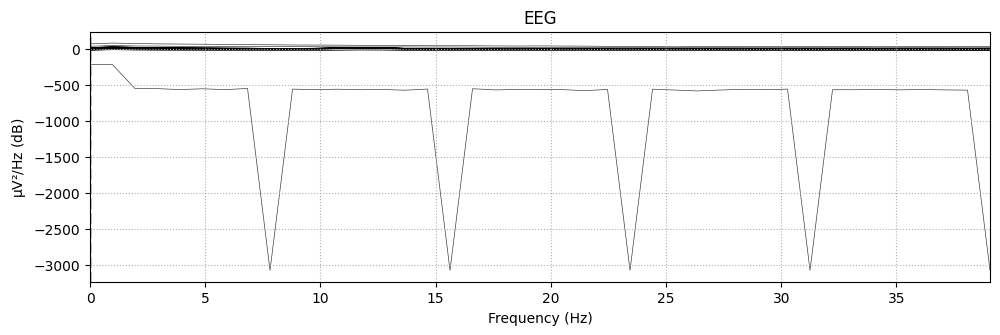

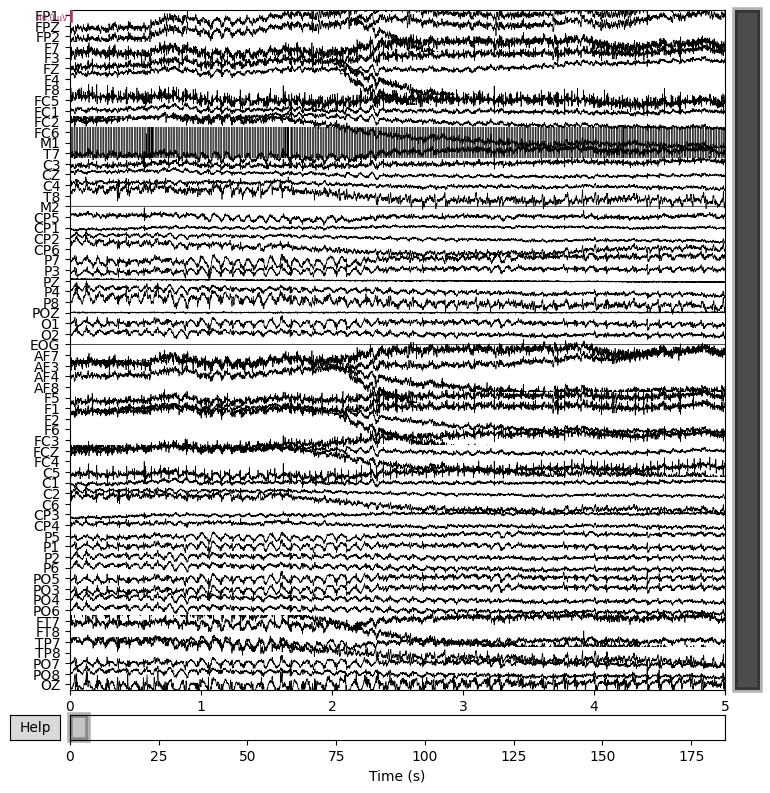

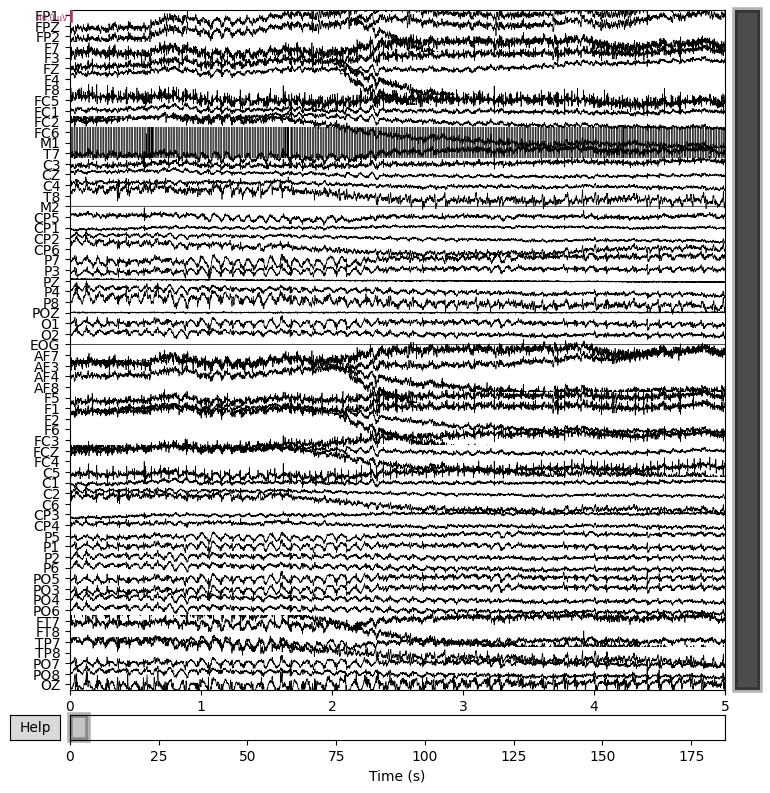

In [8]:
raw.plot_psd(fmax=40)
raw.plot(duration=5, n_channels=64)

In [9]:
original_raw = raw.copy()
rawBP = raw.filter(0.1,40)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 66001 samples (33.001 sec)



In [10]:
### Assesment of bad channels
potential_bad_chs = ['M1','M2','EOG']
rawBP.info['bads'].extend(potential_bad_chs)

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 1.024 (s)


C:\Users\haiou\AppData\Local\Temp\ipykernel_1992\1240145782.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  rawBP.plot_psd(fmax=50,average = False)
c:\Users\haiou\python-env\.venv\env_TNE\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


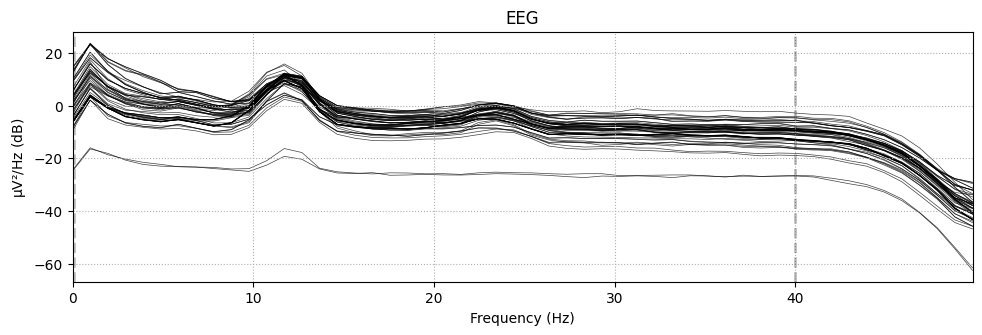

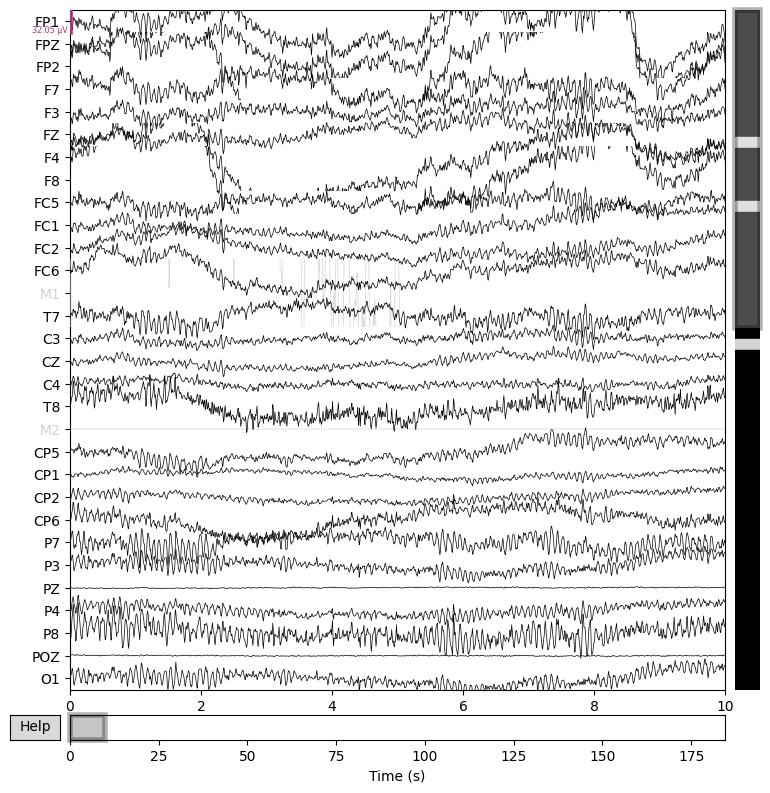

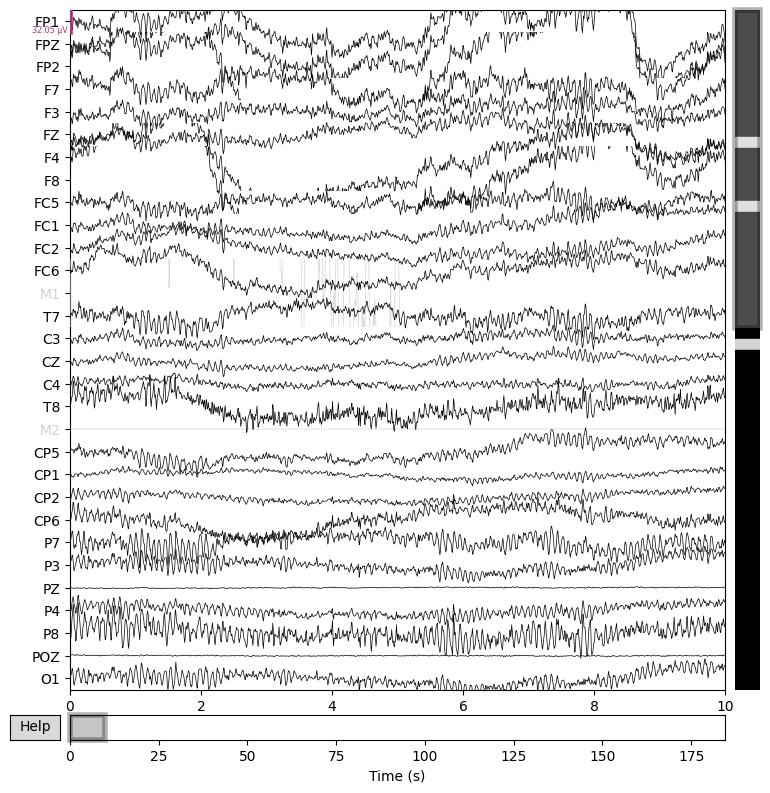

In [11]:
rawBP.plot_psd(fmax=50,average = False)
rawBP.plot(n_channels=30,scalings='auto')

[12, 18]


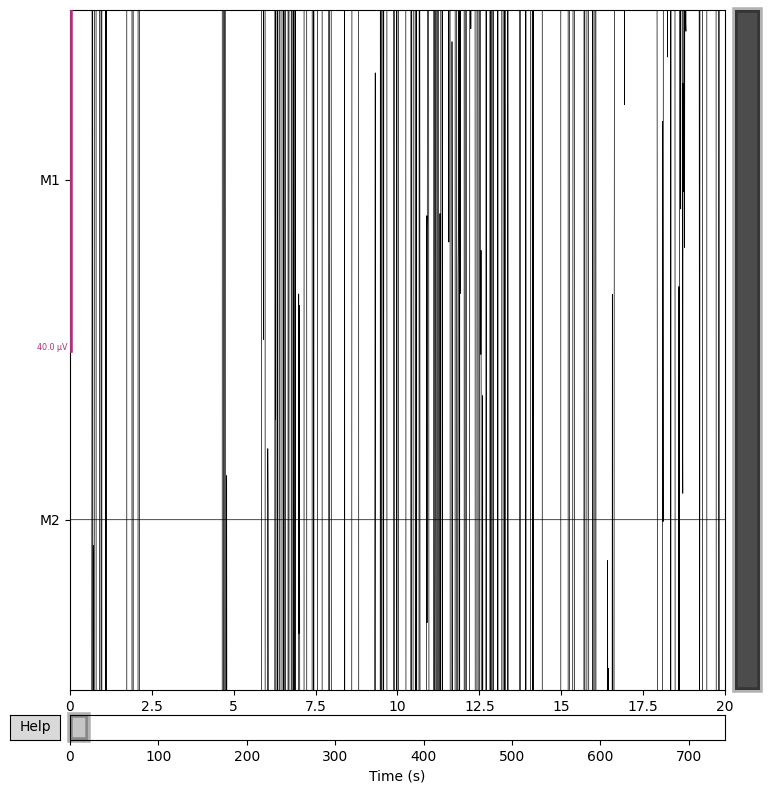

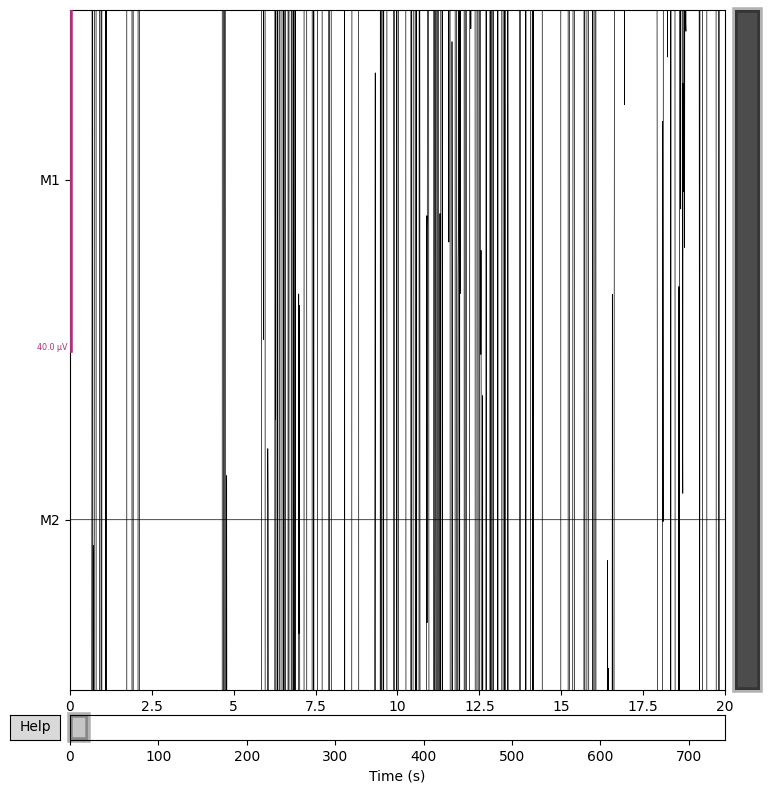

In [20]:
### Plotting of bad channels
picks = mne.pick_channels_regexp(rawBP.ch_names, regexp='M.')
#picks = [filtered_eeg.ch_names.index(ch) for ch in potential_bad_chs]
print(picks)
rawBP.plot(order=picks, n_channels=len(picks),duration=20)

### CAR

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 1.024 (s)


C:\Users\haiou\AppData\Local\Temp\ipykernel_1992\998075210.py:2: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  rawBPCAR.plot_psd(fmax=40)
c:\Users\haiou\python-env\.venv\env_TNE\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


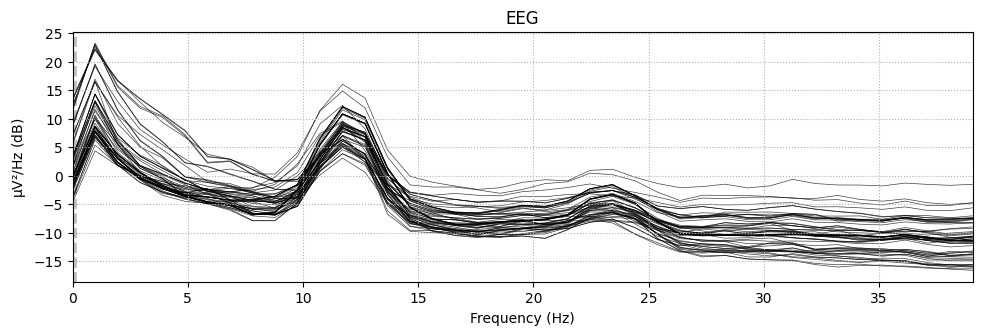

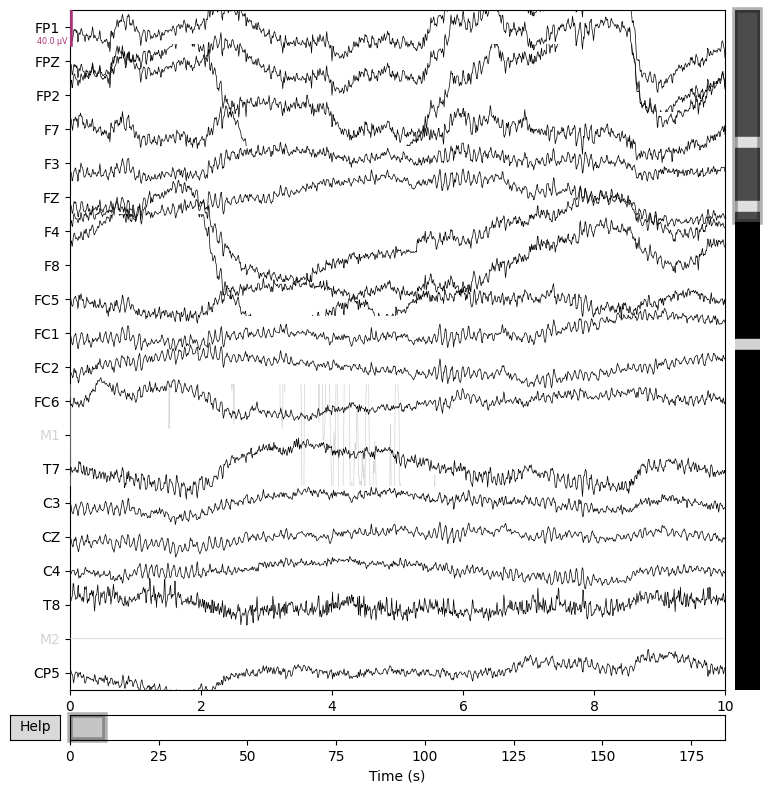

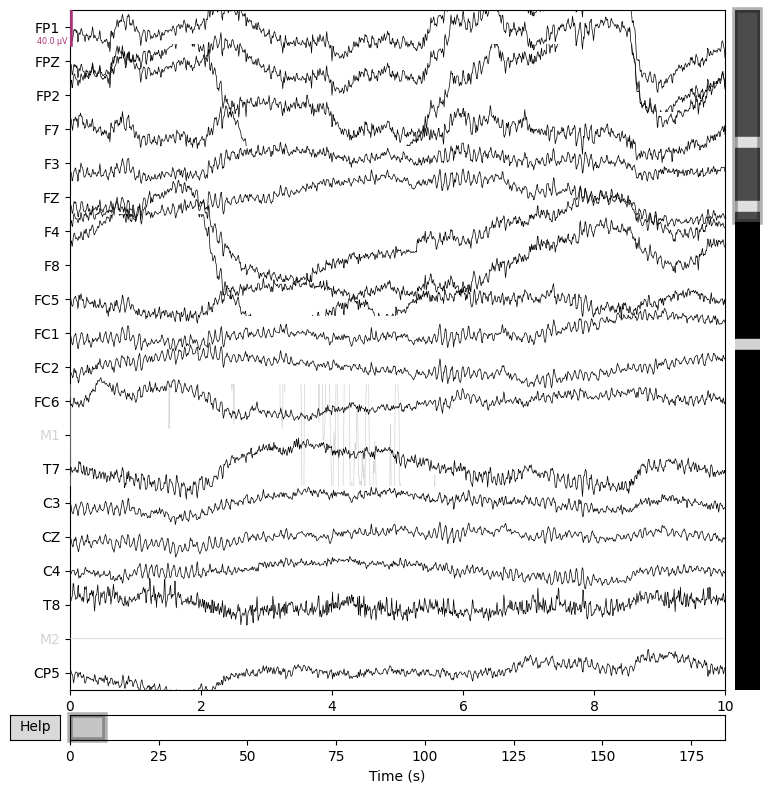

In [16]:
rawBPCAR, ref_data = mne.set_eeg_reference(rawBP, ref_channels='average', copy=True)
rawBPCAR.plot_psd(fmax=40)
rawBPCAR.plot()

### Saving signals

In [32]:
filtered_eeg.save(eeg_files[0]['file'].split('.')[0] + '.fif')

Writing c:\Users\haiou\Documents\TNE\Python\sub-S01_eegBaselineCE.fif


C:\Users\haiou\AppData\Local\Temp\ipykernel_23356\642867268.py:1: RuntimeWarning: This filename (c:\Users\haiou\Documents\TNE\Python\sub-S01_eegBaselineCE.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  filtered_eeg.save(eeg_files[0]['file'].split('.')[0] + '.fif')


Closing c:\Users\haiou\Documents\TNE\Python\sub-S01_eegBaselineCE.fif
[done]


In [33]:
downloaded_eeg = mne.io.read_raw_fif('sub-S01_eegBaselineCE.fif')

Opening raw data file sub-S01_eegBaselineCE.fif...
Isotrak not found
    Range : 0 ... 369015 =      0.000 ...   184.507 secs
Ready.


C:\Users\haiou\AppData\Local\Temp\ipykernel_23356\1747688115.py:1: RuntimeWarning: This filename (sub-S01_eegBaselineCE.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  downloaded_eeg = mne.io.read_raw_fif('sub-S01_eegBaselineCE.fif')


In [35]:
downloaded_eeg.info['bads']

['M1', 'M2', 'EOG']

### Miscellaneous

In [38]:
print(var[2])

{'info': defaultdict(<class 'list'>, {'name': ['eegoSports 000479'], 'type': ['EEG'], 'channel_count': ['66'], 'nominal_srate': ['2000'], 'channel_format': ['double64'], 'source_id': ['eegoSports_000479'], 'version': ['1.1000000000000001'], 'created_at': ['952727.71764649998'], 'uid': ['70610dcd-c5af-42bc-b8e9-97feb2746464'], 'session_id': ['default'], 'hostname': ['LAPTOP-FAE1DJID'], 'v4address': [None], 'v4data_port': ['16575'], 'v4service_port': ['16587'], 'v6address': [None], 'v6data_port': ['16575'], 'v6service_port': ['16587'], 'desc': [defaultdict(<class 'list'>, {'channels': [defaultdict(<class 'list'>, {'channel': [defaultdict(<class 'list'>, {'label': ['FP1'], 'type': ['EEG'], 'unit': ['uV']}), defaultdict(<class 'list'>, {'label': ['FPZ'], 'type': ['EEG'], 'unit': ['uV']}), defaultdict(<class 'list'>, {'label': ['FP2'], 'type': ['EEG'], 'unit': ['uV']}), defaultdict(<class 'list'>, {'label': ['F7'], 'type': ['EEG'], 'unit': ['uV']}), defaultdict(<class 'list'>, {'label': ['F

In [22]:
select_eeg(data)

{'info': defaultdict(list,
             {'name': ['eegoSports 000479'],
              'type': ['EEG'],
              'channel_count': ['66'],
              'nominal_srate': ['2000'],
              'channel_format': ['double64'],
              'source_id': ['eegoSports_000479'],
              'version': ['1.1000000000000001'],
              'created_at': ['952727.71764649998'],
              'uid': ['70610dcd-c5af-42bc-b8e9-97feb2746464'],
              'session_id': ['default'],
              'hostname': ['LAPTOP-FAE1DJID'],
              'v4address': [None],
              'v4data_port': ['16575'],
              'v4service_port': ['16587'],
              'v6address': [None],
              'v6data_port': ['16575'],
              'v6service_port': ['16587'],
              'desc': [defaultdict(list,
                           {'channels': [defaultdict(list,
                                         {'channel': [defaultdict(list,
                                                       {'labe

In [ ]:
for stream in data:
    y = stream['time_series']

    if isinstance(y, list):
        # list of strings, draw one vertical line for each marker
        for timestamp, marker in zip(stream['time_stamps'], y):
            plt.axvline(x=timestamp)
            print(f'Marker "{marker[0]}" @ {timestamp:.2f}s')
    elif isinstance(y, np.ndarray):
        # numeric data, draw as lines
        plt.plot(stream['time_stamps'], y)
    else:
        raise RuntimeError('Unknown stream format')

plt.show()

In [43]:
import pandas as pd
df = pd.read_csv('Data\S01\sub-S01_MIpost.csv')

In [45]:
df

,freq_band,time,condition,epoch,Fc5,Fc1,Fc2,Fc6,C3,Cz,...,Cpz,Fc3,Fcz,Fc4,C5,C1,C2,C6,Cp3,Cp4
0,alpha,0.0,8,1,0.737674,-0.387084,-0.532318,-0.303506,-0.356222,-0.570446,...,0.006941,0.327413,-0.174931,-0.264187,0.033836,-0.618741,-0.405860,0.068062,-0.642695,-0.351382
1,alpha,0.1,8,1,-0.090728,-0.302534,-0.418617,-0.506934,-0.652009,-0.361981,...,-0.041447,-0.081061,-0.114202,-0.498287,-0.361220,-0.382013,-0.360386,-0.546064,-0.622034,-0.604910
2,alpha,0.2,8,1,-0.495979,0.201325,-0.111664,-0.450278,-0.690934,-0.048132,...,-0.178972,0.179857,0.321390,-0.483249,-0.488216,0.037443,-0.153791,-0.476917,-0.654761,-0.409591
3,alpha,0.3,8,1,-0.677237,0.193969,-0.221614,-0.535160,-0.638774,-0.129638,...,-0.137824,0.538399,0.225568,-0.541409,-0.668689,0.123447,-0.325986,-0.421345,-0.653937,-0.404833
4,alpha,0.4,8,1,-0.736904,0.226731,-0.263595,-0.630766,-0.651284,-0.096800,...,-0.181518,0.598548,0.105232,-0.612179,-0.820020,0.227043,-0.480635,-0.405126,-0.683254,-0.395339
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7585,gamma,4.1,2,59,-0.173622,-0.835401,0.027142,0.063384,-0.577456,0.047915,...,0.430760,-0.640266,0.048961,0.105045,-0.223956,-0.599094,-0.662800,-0.422899,0.092654,-0.554683
7586,gamma,4.2,2,59,0.006319,-0.824909,-0.014264,-0.128194,-0.604003,0.147305,...,0.638717,-0.535201,-0.084435,-0.147230,-0.472636,-0.615476,-0.685395,-0.495562,0.070242,-0.522131
7587,gamma,4.3,2,59,0.225318,-0.429956,0.096636,-0.221473,-0.501196,0.202309,...,0.978737,-0.365336,0.215596,-0.264764,-0.393348,-0.599141,-0.519431,-0.434723,0.101006,-0.156882
7588,gamma,4.4,2,59,0.088597,-0.295193,0.167403,-0.237466,-0.437615,-0.156766,...,0.607283,-0.226339,0.320836,-0.308026,-0.336552,-0.733037,-0.487463,-0.327568,-0.195936,-0.071647


In [46]:
data,header = pyxdf.load_xdf('Data\S01\sub-S01_MIpre.xdf')

Stream 2: Calculated effective sampling rate 15487.4688 Hz is different from specified rate 500.0000 Hz.
Stream 1: Calculated effective sampling rate 5192.4441 Hz is different from specified rate 500.0000 Hz.


In [71]:
data[2]['info']['desc'][0]['channels'][0]['channel'][0]['label'][0]

[defaultdict(list, {'label': ['FP1'], 'type': ['EEG'], 'unit': ['uV']}),
 defaultdict(list, {'label': ['FPZ'], 'type': ['EEG'], 'unit': ['uV']}),
 defaultdict(list, {'label': ['FP2'], 'type': ['EEG'], 'unit': ['uV']}),
 defaultdict(list, {'label': ['F7'], 'type': ['EEG'], 'unit': ['uV']}),
 defaultdict(list, {'label': ['F3'], 'type': ['EEG'], 'unit': ['uV']}),
 defaultdict(list, {'label': ['FZ'], 'type': ['EEG'], 'unit': ['uV']}),
 defaultdict(list, {'label': ['F4'], 'type': ['EEG'], 'unit': ['uV']}),
 defaultdict(list, {'label': ['F8'], 'type': ['EEG'], 'unit': ['uV']}),
 defaultdict(list, {'label': ['FC5'], 'type': ['EEG'], 'unit': ['uV']}),
 defaultdict(list, {'label': ['FC1'], 'type': ['EEG'], 'unit': ['uV']}),
 defaultdict(list, {'label': ['FC2'], 'type': ['EEG'], 'unit': ['uV']}),
 defaultdict(list, {'label': ['FC6'], 'type': ['EEG'], 'unit': ['uV']}),
 defaultdict(list, {'label': ['M1'], 'type': ['EEG'], 'unit': ['uV']}),
 defaultdict(list, {'label': ['T7'], 'type': ['EEG'], 'un